In [1]:
#!pip install transformers
!pip install transformers==3.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 769 kB 22.7 MB/s 
     |████████████████████████████████| 880 kB 50.3 MB/s 
     |████████████████████████████████| 3.0 MB 62.9 MB/s 
     |████████████████████████████████| 1.3 MB 57.6 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=53cccc2e51cb8220a5ad089997e2c1e52a5ad3f69092db6882927e4b83b13c30
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [2]:
import matplotlib
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
#from utils import display_pca_scatterplot
import json
import pandas as pd
import random
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import f1_score, classification_report
from spacy.tokenizer import Tokenizer
from spacy.lang.tr import Turkish
import numpy as np
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [3]:
#Modified from https://web.stanford.edu/class/cs224n/materials/Gensim%20word%20vector%20visualization.html
def display_pca_scatterplot(X, y, sample=100):
    indices = np.random.choice(list(range(len(X))), sample)
    X_sample = np.array(X)[indices]
    y_sample = np.array(y)[indices]

    twodim = PCA().fit_transform(X_sample)[:,:2]
    
    plt.figure(figsize=(6,6))
    for idx, el in enumerate(X_sample):
        if y_sample[idx]==2:
            color = 'g'
        elif y_sample[idx]==1:
            color = 'k'
        else:
            color = 'r'
        plt.scatter(el[0], el[1], edgecolors='k', c=color)

    red_patch = mpatches.Patch(color='red', label='Negatif')
    green_patch = mpatches.Patch(color='green', label='Pozitif')
    black_patch = mpatches.Patch(color='black', label='Nötr')
    plt.legend(handles=[green_patch, black_patch, red_patch])

In [10]:
train_path = '/content/datasets/train.json'
val_path = '/content/datasets/validation.json'
test_path = '/content/datasets/test.json' 
netflix_path = '/content/datasets/netflix.json'
device = 'cuda'

In [11]:
def filter(text):
    final_text = ''
    for word in text.split():
        if word.startswith('@'):
            continue
        elif word[-3:] in ['com', 'org']:
            continue
        elif word.startswith('pic') or word.startswith('http') or word.startswith('www'):
            continue
        else:
            final_text += word+' '
    return final_text

In [12]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-128k-uncased")
bert = AutoModel.from_pretrained("dbmdz/bert-base-turkish-128k-uncased").to(device)

def feature_extraction(text):
    x = tokenizer.encode(filter(text))
    with torch.no_grad():
        x, _ = bert(torch.stack([torch.tensor(x)]).to(device))
        return list(x[0][0].cpu().numpy())

#def feature_extraction(text):
#    x = tokenizer.encode(filter(text))    
#    with torch.no_grad():
#        y = bert(torch.stack([torch.tensor(x)]).to(device))
#    return y.last_hidden_state[0][0].cpu().numpy()

In [13]:
with open(train_path, 'r') as f:
    train = json.load(f)
with open(val_path, 'r') as f:
    val = json.load(f)
with open(test_path, 'r') as f:
    test = json.load(f)

train = train+val

In [14]:
mapping = {'negative':0, 'neutral':1, 'positive':2}
X_train = []
y_train = []
X_test = []
y_test = []
for element in tqdm(train):
    X_train.append(feature_extraction(element['sentence']))
    y_train.append(mapping[element['value']])
for element in tqdm(test):
    X_test.append(feature_extraction(element['sentence']))
    y_test.append(mapping[element['value']])

100%|██████████| 3/3 [00:00<00:00, 94.56it/s]


## Visualization of Sentence Vectors

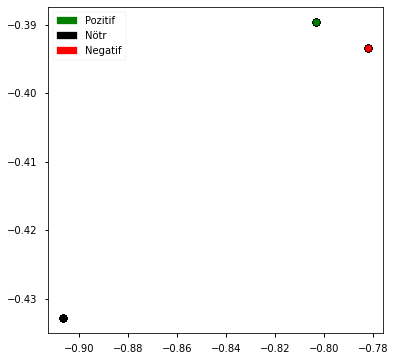

In [15]:
display_pca_scatterplot(X_train, y_train, 500)

## Training a Model with Simple MLP

In [16]:
model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000, activation='tanh', solver='adam', alpha=1e-5, learning_rate='constant',
                      verbose=1, early_stopping=True)
model.fit(X_train, y_train)
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred))

Iteration 1, loss = 1.41572453
Validation score: 0.000000
Iteration 2, loss = 1.24500095
Validation score: 0.000000
Iteration 3, loss = 1.49107417
Validation score: 0.000000
Iteration 4, loss = 1.29236351
Validation score: 0.000000
Iteration 5, loss = 1.11812797
Validation score: 0.000000
Iteration 6, loss = 1.07051821
Validation score: 0.000000
Iteration 7, loss = 1.03149204
Validation score: 0.000000
Iteration 8, loss = 0.99167568
Validation score: 0.000000
Iteration 9, loss = 0.98693160
Validation score: 1.000000
Iteration 10, loss = 1.00469349
Validation score: 1.000000
Iteration 11, loss = 1.00180614
Validation score: 0.000000
Iteration 12, loss = 0.97106366
Validation score: 0.000000
Iteration 13, loss = 0.93873822
Validation score: 0.000000
Iteration 14, loss = 0.92149719
Validation score: 0.000000
Iteration 15, loss = 0.90931992
Validation score: 0.000000
Iteration 16, loss = 0.89087980
Validation score: 0.000000
Iteration 17, loss = 0.87232586
Validation score: 0.000000
Iterat

# Analysis

## Netflix Analysis

In [19]:
netflix_df = pd.read_json(netflix_path).query('is_retweet==False').drop_duplicates(['text'])[['text', 'datetime']]
netflix_df['value'] = 0
#-1 negative 0 neutral 1 positive
for idx, row in tqdm(netflix_df.iterrows()):
    X = feature_extraction(row['text'])
    netflix_df.at[idx, 'value'] = model.predict([X])[0]-1

1000it [00:14, 70.46it/s]


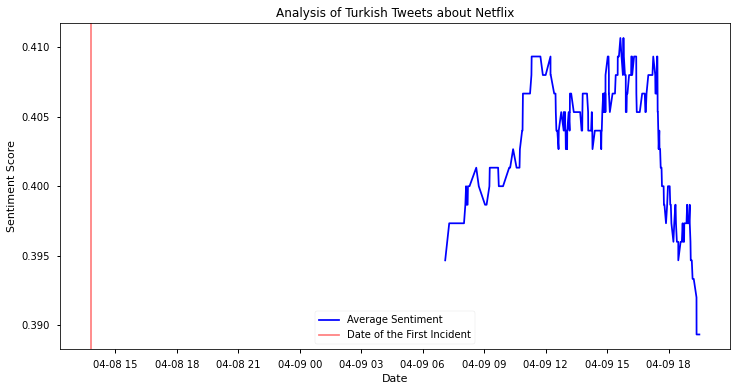

In [20]:
incident1 = datetime.strptime('2020-04-08 13:48:00', '%Y-%m-%d %H:%M:%S')
dates = np.array(netflix_df['datetime'])
indices = np.argsort(dates)
window = 750

dates = dates[indices][window:]
values = np.array(netflix_df['value'])[indices]
windows = pd.Series(values).rolling(window)
moving_averages = windows.mean()[window:]


plt.figure(figsize=(12,6))
plt.plot(dates, moving_averages, color='blue', label='Average Sentiment')

plt.axvline(incident1, 0, 1, label='Date of the First Incident', color='red', alpha=0.5)
plt.title('Analysis of Turkish Tweets about Netflix')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend();